In [ ]:
%matplotlib inline

In [4]:
'''
 * 
 * author Dishant Mittal
 * created on July 10, 2018
 * project MSCI 641
 
 * LDA2Vec is a model that learns dense word vectors jointly with Dirichlet-distributed latent 
 * document-level mixtures of topic vectors. In contrast to continuous dense document 
 * representations, this formulation produces sparse, interpretable document mixtures 
 * through a non-negative simplex constraint.
 *
 
 * In this script, I load the vocabulary, vectors, corpus, docids
 * train a bunch of LDA2Vec models, compute respective topic coherence and perplexity scores
 * Finally print the extarcted topics for the best coherence score.
 .
 '''

import networkx as nx
import matplotlib.pyplot as plt
import pylab
# from __future__ import division
import matplotlib as mpl
import pandas as pd
from operator import itemgetter
import csv
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import re
import numpy as np
import pandas as pd
import sys
print(sys.executable)
import pandas as pd
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# from symspellpy.symspellpy import SymSpell, Verbosity
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import logging
import os
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
pd.set_option('display.max_columns', 136)
pd.set_option('display.max_colwidth', -1)
from nltk.corpus import stopwords, names
import re, unicodedata
from nltk.corpus import names

from lda2vec import preprocess, Corpus
import matplotlib.pyplot as plt
import seaborn
import warnings
import pyLDAvis

import os
import os.path
import pickle
import time
import shelve

import chainer
from chainer import cuda
from chainer import serializers
import chainer.optimizers as O
import numpy as np

from lda2vec import utils
from lda2vec import prepare_topics, print_top_words_per_topic, topic_coherence
from lda2vec import LDA2Vec

/home/dishant/anaconda3/bin/python


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dishant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
gpu_id = int(os.getenv('CUDA_GPU', 0))
cuda.get_device(gpu_id).use()
print("Using GPU:" + str(gpu_id))

Using GPU:0


In [3]:
#data_dir = os.getenv('data_dir', '../data/')
fn_vocab = 'vocab.pkl'
fn_corpus = 'corpus.pkl'
fn_flatnd = 'flattened.npy'
fn_docids = 'doc_ids.npy'
fn_vectors = 'vectors.npy'
vocab = pickle.load(open(fn_vocab, 'rb'))
corpus = pickle.load(open(fn_corpus, 'rb'))
flattened = np.load(fn_flatnd)
doc_ids = np.load(fn_docids)
vectors = np.load(fn_vectors)

In [4]:
# Model Parameters
# Number of documents
n_docs = doc_ids.max() + 1
# Number of unique words in the vocabulary
n_vocab = flattened.max() + 1
# 'Strength' of the dircihlet prior; 200.0 seems to work well
clambda = 200.0
# Number of topics to fit
n_topics = int(os.getenv('n_topics', 20))
batchsize = 4096
# Intialize with pretrained word vectors
pretrained = bool(int(os.getenv('pretrained', True)))
# Number of dimensions in a single word vector
n_units = int(os.getenv('n_units', 300))
# Get the string representation for every compact key
words = corpus.word_list(vocab)[:n_vocab]
# How many tokens are in each document
doc_idx, lengths = np.unique(doc_ids, return_counts=True)
doc_lengths = np.zeros(doc_ids.max() + 1, dtype='int32')
doc_lengths[doc_idx] = lengths
# Count all token frequencies
tok_idx, freq = np.unique(flattened, return_counts=True)
term_frequency = np.zeros(n_vocab, dtype='int32')
term_frequency[tok_idx] = freq

In [2]:
for key in sorted(locals().keys()):
    val = locals()[key]
    if len(str(val)) < 100 and '<' not in str(val):
        print(key, val)

_ 11009
_25 11009
__doc__ Automatically created module for IPython interactive environment
__loader__ None
__name__ __main__
__package__ None
__spec__ None
_dh ['/home/dishant/projects/MSCI_641_proj/lda2vec]
_i len(model.mixture.weights.W)
_i13 serializers.load_npz('my.model', model)
_i14 serializers.load_npz('lda2vec.hdf5', model)
_i15 serializers.load_npz('lda2vec', model)
_i16 serializers.load_hdf5("lda2vec.hdf5")
_i17 serializers.load_hdf5("lda2vec.hdf5"), model)
_i18 serializers.load_hdf5("lda2vec.hdf5", model)
_i19 model
_i20 model
_i21 import pickle
_i22 with open("lda2vec.pkl", "w"):
    pickle.dump(model)
_i23 with open("lda2vec.pkl", "w") as f:
    pickle.dump(model, f)
_i24 with open("lda2vec.pkl", "wb") as f:
    pickle.dump(model, f)
_i25 len(model.mixture.weights.W)
_ii with open("lda2vec.pkl", "wb") as f:
    pickle.dump(model, f)
_iii with open("lda2vec.pkl", "w") as f:
    pickle.dump(model, f)
batchsize 4096
clambda 200.0
d [6535 6535 6535 ... 6535 6535 6535]
doc_ids 

# training the model

In [2]:
begin=2
end=23

In [9]:
def compute_coherence_values(limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    start : start num of topics
    step : step we should take
    limit : Max num of topics

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA2Vec models with respective number of topics
    perplexity_values : Perplexity values corresponding to the LDA2Vec models with respect to number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA2Vec(n_documents=n_docs, n_document_topics=n_topics,
                n_units=n_units, n_vocab=n_vocab, counts=term_frequency,
                n_samples=15)
        
#         if os.path.exists('lda2vec.hdf5'):
#             print("Reloading from saved")
#         serializers.load_hdf5("lda2vec.hdf5", model)
    
        if pretrained:
            model.sampler.W.data[:, :] = vectors[:n_vocab, :]
        
        model.to_gpu()
        optimizer = O.Adam()
        optimizer.setup(model)
        clip = chainer.optimizer.GradientClipping(5.0)
        optimizer.add_hook(clip)
            
        j = 0
        epoch = 0
        fraction = batchsize * 1.0 / flattened.shape[0]
        progress = shelve.open('progress.shelve')
        
        for epoch in range(1):
            data = prepare_topics(cuda.to_cpu(model.mixture.weights.W.data).copy(),
                                  cuda.to_cpu(model.mixture.factors.W.data).copy(),
                                  cuda.to_cpu(model.sampler.W.data).copy(),
                                  words)
            top_words = print_top_words_per_topic(data)
            if j % 100 == 0 and j > 100:
                coherence = topic_coherence(top_words)
                coherence_values.append(coherence)
                perplexity_values.append(model.log_perplexity(corpus))
#                 for j in range(n_topics):
#                     print(j, coherence[(j, 'cv')])
                kw = dict(top_words=top_words, coherence=coherence, epoch=epoch)
                progress[str(epoch)] = pickle.dumps(kw)
            data['doc_lengths'] = doc_lengths
            data['term_frequency'] = term_frequency
            np.savez('topics_'+str(num_topics)+'.pyldavis', **data)
            print(epoch)
            for d, f in utils.chunks(batchsize, doc_ids, flattened):
                t0 = time.time()
                model.cleargrads()
                #optimizer.use_cleargrads(use=False)
                l = model.fit_partial(d.copy(), f.copy())
                print("after partial fitting:", l)
                prior = model.prior()
                loss = prior * fraction
                loss.backward()
                optimizer.update()
                msg = ("J:{j:05d} E:{epoch:05d} L:{loss:1.3e} "
                       "P:{prior:1.3e} R:{rate:1.3e}")
                prior.to_cpu()
                loss.to_cpu()
                t1 = time.time()
                dt = t1 - t0
                rate = batchsize / dt
                logs = dict(loss=float(l), epoch=epoch, j=j,
                            prior=float(prior.data), rate=rate)
                print(msg.format(**logs))
                j += 1
            serializers.save_hdf5("lda2vec_"+str(num_topics)+".hdf5", model)
    return coherence_values, perplexity_values
    
coherence_values, perplexity_values = compute_coherence_values(limit=end,start=begin, step=1)
    


0
after partial fitting: 60438.6
J:00000 E:00000 L:6.003e+04 P:-6.266e+05 R:2.56e+03
after partial fitting: 59365.18
J:00001 E:00000 L:5.997e+04 P:-6.266e+05 R:4.747e+03
after partial fitting: 58314.625
J:00002 E:00000 L:5.881e+04 P:-6.266e+05 R:4.773e+03
after partial fitting: 58210.41
J:00003 E:00000 L:5.823e+04 P:-6.266e+05 R:4.794e+03
after partial fitting: 57322.15
J:00004 E:00000 L:5.757e+04 P:-6.266e+05 R:6.067e+03
after partial fitting: 53947.297
J:00005 E:00000 L:5.396e+04 P:-6.266e+05 R:6.023e+03
after partial fitting: 55930.78
J:00006 E:00000 L:5.561e+04 P:-6.266e+05 R:5.891e+03
after partial fitting: 55198.6
J:00007 E:00000 L:5.572e+04 P:-6.266e+05 R:5.802e+03
after partial fitting: 54259.97
J:00008 E:00000 L:5.491e+04 P:-6.266e+05 R:5.911e+03
after partial fitting: 53028.777
J:00009 E:00000 L:5.357e+04 P:-6.266e+05 R:5.880e+03
after partial fitting: 52118.152
J:00010 E:00000 L:5.267e+04 P:-6.266e+05 R:5.919e+03
after partial fitting: 54095.47
J:00011 E:00000 L:5.433e+04 P

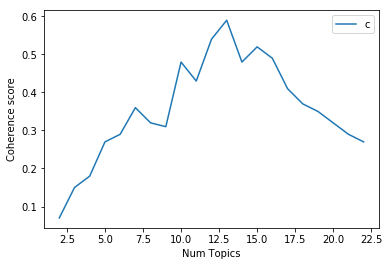

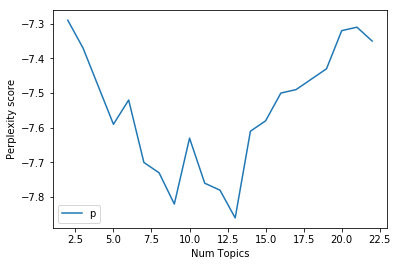

Num Topics = 2  has Coherence Value of 0.07
Num Topics = 3  has Coherence Value of 0.15
Num Topics = 4  has Coherence Value of 0.18
Num Topics = 5  has Coherence Value of 0.27
Num Topics = 6  has Coherence Value of 0.29
Num Topics = 7  has Coherence Value of 0.36
Num Topics = 8  has Coherence Value of 0.32
Num Topics = 9  has Coherence Value of 0.31
Num Topics = 10  has Coherence Value of 0.48
Num Topics = 11  has Coherence Value of 0.43
Num Topics = 12  has Coherence Value of 0.54
Num Topics = 13  has Coherence Value of 0.59
Num Topics = 14  has Coherence Value of 0.48
Num Topics = 15  has Coherence Value of 0.52
Num Topics = 16  has Coherence Value of 0.49
Num Topics = 17  has Coherence Value of 0.41
Num Topics = 18  has Coherence Value of 0.37
Num Topics = 19  has Coherence Value of 0.35
Num Topics = 20  has Coherence Value of 0.32
Num Topics = 21  has Coherence Value of 0.29
Num Topics = 22  has Coherence Value of 0.27
coherence values computed
Num Topics = 2  has Perplexity Value 

In [8]:
############################################################### Show graph
limit=end; start=begin; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('coherence.png')
plt.show()
##############################################################

plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.savefig('perplexity.png')
plt.show()
##########################




#Topic models are evaluated based on their ability to describe documents well (i.e. low perplexity) 
#and to produce topics that carry coherent semantic meaning (high coherence).

#perplexity:inability to deal with or understand something complicated or unaccountable.
#coherence: the quality of forming a unified whole
#ultimate aim is to make perplexity as low as possible and coherence as high as possible
count=1
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
print("coherence values computed")

for m, cv in zip(x, perplexity_values):
    print("Num Topics =", m, " has Perplexity Value of", round(cv, 4))
print("perplexity values computed")


In [6]:
npz = np.load(open('topics_13.pyldavis.npz', 'rb'))
dat = {k: v for (k, v) in npz.iteritems()}
dat['vocab'] = dat['vocab'].tolist()

print("loaded")

loaded


In [17]:
top_n = 5
topic_to_topwords = {}
for j, topic_to_word in enumerate(dat['topic_term_dists']):
    top = np.argsort(topic_to_word)[::-1][:top_n]
    msg = 'Topic %i '  % j
    top_words = [dat['vocab'][i].strip()[:35] for i in top]
    msg += ' '.join(top_words)
    print(msg)
    topic_to_topwords[j] = top_words


Topic 0 countries whales coackroaches rabbies dogs
Topic 1 immunotherapy nasal dementia allergy hazard
Topic 2 gasoline biofuel emission renewable rocket
Topic 3 anxiety health twitches muscle prescription
Topic 4 murder detained death alive remembering
Topic 5 scoliosis back chronic stretches smoking
Topic 6 fungus pots fatal flu water
Topic 7 chicken bird air flight turkey
Topic 8 corruption democracy vote indict pirate
Topic 9 cybercrime wallet digital ransomware security
Topic 10 fat diet carbs recipe summer 
Topic 11 disney vacation money budget theme
Topic 12 student psychology education success teacher

